---

# 0. Imports

In [2]:
# Basic imports
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import pickle

# Functional imports
import json
import pyarrow
from pickle import dump
import gc
import streamlit as st
import datetime

# Model imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest

pd.set_option('display.max_columns', None)

---

# 1. Data Collection

In [3]:
#df_2018 = pd.read_parquet("../data/raw/Combined_Flights_2018.parquet", engine="pyarrow")
#df_2019 = pd.read_parquet("../data/raw/Combined_Flights_2019.parquet", engine="pyarrow")
#df_2020 = pd.read_parquet("../data/raw/Combined_Flights_2020.parquet", engine="pyarrow")
#df_2021 = pd.read_parquet("../data/raw/Combined_Flights_2021.parquet", engine="pyarrow")
df = pd.read_parquet("../data/raw/Combined_Flights_2022.parquet", engine="pyarrow")


In [3]:
#data_frames = [df_2018, df_2019, df_2020, df_2021, df_2022]
#df = pd.concat(data_frames, ignore_index=True)

In [4]:
df.head(3)

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",GJT,DEN,False,False,1133,1123.0,0.0,-10.0,1228.0,0.0,40.0,72.0,65.0,212.0,2022,2,4,4,1,UA,UA_CODESHARE,19977,UA,4301,C5,20445,C5,N21144,4301,11921,1192102,31921,"Grand Junction, CO",CO,8,Colorado,82,11292,1129202,30325,"Denver, CO",CO,8,Colorado,82,0.0,-1.0,1100-1159,17.0,1140.0,1220.0,8.0,1245,-17.0,0.0,-2.0,1200-1259,1,0
1,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",HRL,IAH,False,False,732,728.0,0.0,-4.0,848.0,0.0,55.0,77.0,80.0,295.0,2022,2,4,4,1,UA,UA_CODESHARE,19977,UA,4299,C5,20445,C5,N16170,4299,12206,1220605,32206,"Harlingen/San Benito, TX",TX,48,Texas,74,12266,1226603,31453,"Houston, TX",TX,48,Texas,74,0.0,-1.0,0700-0759,16.0,744.0,839.0,9.0,849,-1.0,0.0,-1.0,0800-0859,2,0
2,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,False,False,1529,1514.0,0.0,-15.0,1636.0,0.0,47.0,70.0,82.0,251.0,2022,2,4,4,1,UA,UA_CODESHARE,19977,UA,4298,C5,20445,C5,N21144,4298,11413,1141307,30285,"Durango, CO",CO,8,Colorado,82,11292,1129202,30325,"Denver, CO",CO,8,Colorado,82,0.0,-1.0,1500-1559,21.0,1535.0,1622.0,14.0,1639,-3.0,0.0,-1.0,1600-1659,2,0


---

## Cargar archivos parquet de todos los años

import pandas as pd 
#Cargar datos de múltiples años 
Archivos = [“../data/raw/Combined_Flights_2018.parquet", 
"../data/raw/Combined_Flights_2019.parquet", 
"../data/raw/Combined_Flights_2020.parquet", 
"../data/raw/Combined_Flights_2021.parquet", 
"../data/raw/Combined_Flights_2022.parquet"] 

df_list = [pd.read_parquet(file, engine="pyarrow") for file in Archivos] 

#Concatenar todos los datos 

df = pd.concat(df_list, ignore_index=True) 

# Guardar el dataset combinado 
df.to_parquet("../data/raw/Combined_Flights_All_Years.parquet", engine="pyarrow")

# 2 Exploration and Data cleaning

## Explicación de Columnas - Dataset de Vuelos

### Información del Vuelo
* **FlightDate**: Fecha del vuelo (año, mes y día)
* **Airline**: Código de aerolínea operadora
* **Origin**: Código IATA aeropuerto origen
* **Dest**: Código IATA aeropuerto destino

### Indicadores de Interrupción
* **Cancelled**: Vuelo cancelado (1=Sí, 0=No)
* **Diverted**: Vuelo desviado (1=Sí, 0=No)

### Horarios y Retrasos
#### Salida
* **CRSDepTime**: Hora programada salida
* **DepTime**: Hora real salida
* **DepDelayMinutes**: Minutos de retraso salida
* **DepDelay**: Retraso salida (negativo=anticipado)

#### Llegada
* **ArrTime**: Hora real llegada
* **ArrDelayMinutes**: Minutos retraso llegada 
* **ArrDelay**: Retraso llegada (negativo=anticipada)

### Duración
* **AirTime**: Minutos en aire
* **CRSElapsedTime**: Tiempo estimado total
* **ActualElapsedTime**: Tiempo real total

### Geografía y Tiempo
* **Distance**: Distancia en millas
* **Year**: Año del vuelo
* **Quarter**: Trimestre (1-4)
* **Month**: Mes (1-12)
* **DayofMonth**: Día del mes
* **DayOfWeek**: Día semana (1=Lunes, 7=Domingo)

### Información Aerolíneas
* **Marketing_Airline_Network**: Aerolínea vendedora
* **Operating_Airline**: Aerolínea operadora física
* **DOT_ID_Marketing_Airline**: ID DOT aerolínea marketing
* **IATA_Code_Marketing_Airline**: Código IATA aerolínea marketing
* **Flight_Number_Marketing_Airline**: Número vuelo marketing
* **DOT_ID_Operating_Airline**: ID DOT aerolínea operadora
* **IATA_Code_Operating_Airline**: Código IATA aerolínea operadora

### Aeronave
* **Tail_Number**: Matrícula única
* **Flight_Number_Operating_Airline**: Número vuelo operativo

### Aeropuerto Origen
* **OriginAirportID**: ID único
* **OriginAirportSeqID**: ID secuencia
* **OriginCityMarketID**: ID mercado ciudad
* **OriginCityName**: Nombre ciudad
* **OriginState**: Abreviación estado
* **OriginStateFips**: Código FIPS estado
* **OriginStateName**: Nombre estado
* **OriginWac**: Código WAC

### Aeropuerto Destino
* **DestAirportID**: ID único
* **DestAirportSeqID**: ID secuencia
* **DestCityMarketID**: ID mercado ciudad
* **DestCityName**: Nombre ciudad
* **DestState**: Abreviación estado
* **DestStateFips**: Código FIPS estado
* **DestStateName**: Nombre estado
* **DestWac**: Código WAC

### Indicadores Retraso Salida
* **DepDel15**: Retraso >15 min (1=Sí, 0=No)
* **DepartureDelayGroups**: Grupos de retraso
* **DepTimeBlk**: Bloque horario (ej: "0700-0759")

### Movimientos Aeronave
* **TaxiOut**: Minutos en pista antes despegue
* **WheelsOff**: Hora despegue
* **WheelsOn**: Hora aterrizaje
* **TaxiIn**: Minutos en pista post-aterrizaje

### Indicadores Retraso Llegada
* **CRSArrTime**: Hora programada llegada
* **ArrDel15**: Retraso >15 min (1=Sí, 0=No)
* **ArrivalDelayGroups**: Grupos de retraso
* **ArrTimeBlk**: Bloque horario llegada

### Otros Indicadores
* **DistanceGroup**: Grupos por distancia
* **DivAirportLandings**: Aterrizajes no programados

In [5]:
print('Our dataframe contains {} rows and it has {} features.'.format(len(df), df.shape[1]))

Our dataframe contains 4078318 rows and it has 61 features.


---

## 2.2 Eliminating Irrelevant Features and dealing with null values

Eliminaremos algunos features antes de continuar con nuestro EDA para ahorrar en recursos y tiempo

In [6]:
columnas_necesarias = [
   'DayOfWeek',
   'Month',
   'Quarter',
   'DayofMonth',
   'DepDelayMinutes',
   'DepTime',
   'CRSDepTime',
   'Distance',
   'Airline',
   'OriginStateName',
   'DestStateName',
   'OriginCityName',
   'DestCityName'
]

In [7]:
df = df[columnas_necesarias]
df.head(3)

,DayOfWeek,Month,Quarter,DayofMonth,DepDelayMinutes,DepTime,CRSDepTime,Distance,Airline,OriginStateName,DestStateName,OriginCityName,DestCityName
0,1,4,2,4,0.0,1123.0,1133,212.0,"Commutair Aka Champlain Enterprises, Inc.",Colorado,Colorado,"Grand Junction, CO","Denver, CO"
1,1,4,2,4,0.0,728.0,732,295.0,"Commutair Aka Champlain Enterprises, Inc.",Texas,Texas,"Harlingen/San Benito, TX","Houston, TX"
2,1,4,2,4,0.0,1514.0,1529,251.0,"Commutair Aka Champlain Enterprises, Inc.",Colorado,Colorado,"Durango, CO","Denver, CO"


In [8]:
df.columns

Index(['DayOfWeek', 'Month', 'Quarter', 'DayofMonth', 'DepDelayMinutes',
       'DepTime', 'CRSDepTime', 'Distance', 'Airline', 'OriginStateName',
       'DestStateName', 'OriginCityName', 'DestCityName'],
      dtype='object')

In [9]:
df.shape

(4078318, 13)

In [10]:
def estratificar_datos(df, target_col='DepDelayMinutes', sample_size=1000000):
    """
    Realiza un muestreo estratificado manteniendo las proporciones de las variables.
    
    Parámetros:
    df: DataFrame original
    
    target_col: Nombre de la columna objetivo
    sample_size: Tamaño deseado de la muestra
    """
    
    # Crear bins para la variable objetivo (DepDelayMinutes)
    df['delay_category'] = pd.qcut(df[target_col], q=10, labels=False, duplicates='drop')
    
    # Crear una categoría combinada para la estratificación
    df['strata'] = df['delay_category'].astype(str) + '_' + \
                   df['Airline'].astype(str) + '_' + \
                   df['Quarter'].astype(str)
    
    # Calcular el tamaño proporcional para cada estrato
    proportions = df['strata'].value_counts(normalize=True)
    
    # Inicializar DataFrame vacío para la muestra
    stratified_sample = pd.DataFrame()
    
    # Realizar el muestreo estratificado
    for stratum in proportions.index:
        stratum_size = int(proportions[stratum] * sample_size)
        if stratum_size > 0:
            stratum_sample = df[df['strata'] == stratum].sample(
                n=min(stratum_size, len(df[df['strata'] == stratum])),
                random_state=42
            )
            stratified_sample = pd.concat([stratified_sample, stratum_sample])
    
    # Eliminar columnas auxiliares
    stratified_sample = stratified_sample.drop(['delay_category', 'strata'], axis=1)
    
    return stratified_sample

# Uso del código
# Asumiendo que tu DataFrame original se llama 'df'
# df = pd.read_csv('tu_archivo.csv')

# Crear muestra estratificada
muestra_estratificada = estratificar_datos(
    df,
    target_col='DepDelayMinutes',
    sample_size= 1450000  # Ajusta este número según tus necesidades
)

# Verificar las proporciones
def verificar_proporciones(df_original, df_muestra):
    """
    Compara las proporciones de las variables clave entre el DataFrame original y la muestra
    """
    variables_check = ['Airline', 'Quarter', 'DepDelayMinutes']
    
    for var in variables_check:
        if var == 'DepDelayMinutes':
            # Para variables numéricas, comparamos estadísticas descriptivas
            print(f"\nEstadísticas de {var}:")
            print("\nOriginal:")
            print(df_original[var].describe())
            print("\nMuestra:")
            print(df_muestra[var].describe())
        else:
            # Para variables categóricas, comparamos proporciones
            print(f"\nProporciones de {var}:")
            print("\nOriginal:")
            print(df_original[var].value_counts(normalize=True))
            print("\nMuestra:")
            print(df_muestra[var].value_counts(normalize=True))

# Verificar las proporciones
verificar_proporciones(df, muestra_estratificada)


Proporciones de Airline:

Original:
Airline
Southwest Airlines Co.                       0.179467
Delta Air Lines Inc.                         0.125570
American Airlines Inc.                       0.121607
SkyWest Airlines Inc.                        0.108085
United Air Lines Inc.                        0.086312
Republic Airlines                            0.048520
JetBlue Airways                              0.038446
Envoy Air                                    0.036966
Endeavor Air Inc.                            0.034971
Comair Inc.                                  0.033319
Alaska Airlines Inc.                         0.031756
Spirit Air Lines                             0.031682
Frontier Airlines Inc.                       0.021224
Allegiant Air                                0.018023
Mesa Airlines Inc.                           0.017647
Horizon Air                                  0.013810
Capital Cargo International                  0.012953
Commutair Aka Champlain Enterprises, 

### Análisis de Variables Seleccionadas para Predicción de Retrasos en Vuelos

### Variables Temporales
- `Month`, `DayOfWeek`: Capturan patrones estacionales y semanales
- `CRSDepTime`: Hora programada, afecta probabilidad de retrasos
- `DepTime`: Hora real de salida, necesaria para validación

### Variables Operativas
- `Airline`: Diferentes aerolíneas tienen distintos índices de puntualidad
- `Distance`: Factor crítico que afecta complejidad operativa
- `DepDelayMinutes`: Variable objetivo para predicción

### Variables Geográficas
- `Origin`, `Dest`: Identificadores de aeropuertos
- `OriginAirportID`: Identificador único para análisis consistente
- `OriginStateName`, `DestStateName`: Factores climatológicos regionales
- `DestCityName`: Patrones específicos de destinos urbanos

### Variables Excluidas y Razones
- Variables redundantes (ej: `DepDelay`, similar a `DepDelayMinutes`)
- Datos post-evento (ej: `ArrTime`, `AirTime`)
- Información detallada no predictiva (ej: `TailNumber`)
- Variables derivadas calculables desde las seleccionadas

## 2.3 Analisis de nuestra dataframe

In [11]:
df.describe()

,DayOfWeek,Month,Quarter,DayofMonth,DepDelayMinutes,DepTime,CRSDepTime,Distance,delay_category
count,4.078318e+06,4.078318e+06,4.078318e+06,4.078318e+06,3.957823e+06,3.957885e+06,4.078318e+06,4.078318e+06,3.957823e+06
mean,4.005566e+00,4.083803e+00,1.741207e+00,1.571131e+01,1.601494e+01,1.334374e+03,1.329587e+03,7.978657e+02,5.911313e-01
std,2.007050e+00,1.998918e+00,7.037563e-01,8.760122e+00,5.231498e+01,5.056219e+02,4.904801e+02,5.914742e+02,1.016431e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.100000e+01,0.000000e+00
25%,2.000000e+00,2.000000e+00,1.000000e+00,8.000000e+00,0.000000e+00,9.170000e+02,9.140000e+02,3.680000e+02,0.000000e+00
50%,4.000000e+00,4.000000e+00,2.000000e+00,1.600000e+01,0.000000e+00,1.325000e+03,1.320000e+03,6.430000e+02,0.000000e+00
75%,6.000000e+00,6.000000e+00,2.000000e+00,2.300000e+01,1.100000e+01,1.744000e+03,1.735000e+03,1.035000e+03,1.000000e+00
max,7.000000e+00,7.000000e+00,3.000000e+00,3.100000e+01,7.223000e+03,2.400000e+03,2.359000e+03,5.095000e+03,3.000000e+00


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4078318 entries, 0 to 590541
Data columns (total 15 columns):
 #   Column           Dtype  
---  ------           -----  
 0   DayOfWeek        int64  
 1   Month            int64  
 2   Quarter          int64  
 3   DayofMonth       int64  
 4   DepDelayMinutes  float64
 5   DepTime          float64
 6   CRSDepTime       int64  
 7   Distance         float64
 8   Airline          object 
 9   OriginStateName  object 
 10  DestStateName    object 
 11  OriginCityName   object 
 12  DestCityName     object 
 13  delay_category   float64
 14  strata           object 
dtypes: float64(4), int64(5), object(6)
memory usage: 497.8+ MB


***Coclusion:***

Nuestro data frame contiene los siguientes tipos de datos:

- ``Float``     --> 3
- ``Integer``   --> 4
- ``String``    --> 7



## 2.4 Buscando duplicados, valores vacios y lidiando con ellos

In [13]:
df.duplicated().sum()

np.int64(92)

In [14]:
df = df.drop_duplicates()

In [15]:
df.duplicated().sum()

np.int64(0)

In [16]:
df.isna().sum()[df.isna().sum()>0]

DepDelayMinutes    120483
DepTime            120421
delay_category     120483
dtype: int64

In [17]:
df = df.dropna()

In [18]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

***Conclusion:***

De aproximadamente 29M de filas se encontrarons solo 573 filas duplicadas y 762978 de valores nulos

Sabiendo estos numeros lo que haremos seremos eliminarlos para que no afecte en el analisis de datos. Esta decision fue tomada considerando que al ser un porcentaje bajo de data no afectara al momento del analisis

---

# 3. Casting

## 3.1 Dividing our dataset into categorical, numerical and temporal 

In [19]:
# Understanding how many type of features we have
df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [20]:
num = ["float64", "int64"]
cat = ['O']
temp = ['datetime64']

df_num = df.select_dtypes(num)
df_cat = df.select_dtypes(cat)
df_temp = df.select_dtypes(temp)

In [21]:
#Numerical Dataframe
df_num.head(3)

,DayOfWeek,Month,Quarter,DayofMonth,DepDelayMinutes,DepTime,CRSDepTime,Distance,delay_category
0,1,4,2,4,0.0,1123.0,1133,212.0,0.0
1,1,4,2,4,0.0,728.0,732,295.0,0.0
2,1,4,2,4,0.0,1514.0,1529,251.0,0.0


In [22]:
#Categorical Dataframe
df_cat.head(3)

,Airline,OriginStateName,DestStateName,OriginCityName,DestCityName,strata
0,"Commutair Aka Champlain Enterprises, Inc.",Colorado,Colorado,"Grand Junction, CO","Denver, CO","0.0_Commutair Aka Champlain Enterprises, Inc._2"
1,"Commutair Aka Champlain Enterprises, Inc.",Texas,Texas,"Harlingen/San Benito, TX","Houston, TX","0.0_Commutair Aka Champlain Enterprises, Inc._2"
2,"Commutair Aka Champlain Enterprises, Inc.",Colorado,Colorado,"Durango, CO","Denver, CO","0.0_Commutair Aka Champlain Enterprises, Inc._2"


In [23]:
valores_unicos_df_cat = df_cat["Airline"].unique()
print(valores_unicos_df_cat)

['Commutair Aka Champlain Enterprises, Inc.'
 'GoJet Airlines, LLC d/b/a United Express' 'Air Wisconsin Airlines Corp'
 'Mesa Airlines Inc.' 'Southwest Airlines Co.' 'Republic Airlines'
 'Endeavor Air Inc.' 'American Airlines Inc.'
 'Capital Cargo International' 'SkyWest Airlines Inc.'
 'Alaska Airlines Inc.' 'JetBlue Airways' 'Delta Air Lines Inc.'
 'Frontier Airlines Inc.' 'Allegiant Air' 'Hawaiian Airlines Inc.'
 'Envoy Air' 'Spirit Air Lines' 'Comair Inc.' 'Horizon Air'
 'United Air Lines Inc.']


In [24]:
df_valores_unicos = pd.DataFrame(valores_unicos_df_cat, columns=["Airline"])
print(df_valores_unicos)

                                      Airline
0   Commutair Aka Champlain Enterprises, Inc.
1    GoJet Airlines, LLC d/b/a United Express
2                 Air Wisconsin Airlines Corp
3                          Mesa Airlines Inc.
4                      Southwest Airlines Co.
5                           Republic Airlines
6                           Endeavor Air Inc.
7                      American Airlines Inc.
8                 Capital Cargo International
9                       SkyWest Airlines Inc.
10                       Alaska Airlines Inc.
11                            JetBlue Airways
12                       Delta Air Lines Inc.
13                     Frontier Airlines Inc.
14                              Allegiant Air
15                     Hawaiian Airlines Inc.
16                                  Envoy Air
17                           Spirit Air Lines
18                                Comair Inc.
19                                Horizon Air
20                      United Air

In [25]:
df_valores_unicos.to_csv("../data/raw/df_valores_unicos.csv", index = False)

In [26]:
valores_unicos_df_cat_origin_name = df_cat["OriginCityName"].unique()
print(valores_unicos_df_cat_origin_name)

['Grand Junction, CO' 'Harlingen/San Benito, TX' 'Durango, CO'
 'Houston, TX' 'Denver, CO' 'Knoxville, TN' 'Mobile, AL' 'Lincoln, NE'
 'Birmingham, AL' 'Washington, DC' 'Panama City, FL' 'Alexandria, LA'
 'Lafayette, LA' 'Baton Rouge, LA' 'Albuquerque, NM' 'Buffalo, NY'
 'Albany, NY' 'Huntsville, AL' 'Tulsa, OK' 'Casper, WY'
 'Corpus Christi, TX' 'Newark, NJ' 'St. Louis, MO' 'Cincinnati, OH'
 'Richmond, VA' 'Providence, RI' 'Charlotte, NC'
 'Greensboro/High Point, NC' 'Erie, PA' 'Chicago, IL' 'Lexington, KY'
 'Allentown/Bethlehem/Easton, PA' 'Akron, OH' 'Asheville, NC' 'Dayton, OH'
 'Charlottesville, VA' 'Roanoke, VA' 'Portland, ME' 'Little Rock, AR'
 'Milwaukee, WI' 'Burlington, VT' 'Omaha, NE' 'Green Bay, WI' 'Moline, IL'
 'Louisville, KY' 'Flint, MI' 'Charleston, SC' 'Pittsburgh, PA'
 'Traverse City, MI' 'Appleton, WI' 'Duluth, MN' 'Rochester, NY'
 'Springfield, IL' 'White Plains, NY' 'Saginaw/Bay City/Midland, MI'
 'Cedar Rapids/Iowa City, IA' 'Myrtle Beach, SC' 'Columbia, SC'
 'Sp

In [27]:
df_valores_unicos_origin = pd.DataFrame(valores_unicos_df_cat_origin_name, columns=["OriginCityName"])
print(df_valores_unicos_origin)

               OriginCityName
0          Grand Junction, CO
1    Harlingen/San Benito, TX
2                 Durango, CO
3                 Houston, TX
4                  Denver, CO
..                        ...
364              Gustavus, AK
365     Martha's Vineyard, MA
366               Hyannis, MA
367                Pierre, SD
368             Watertown, SD

[369 rows x 1 columns]


In [28]:
df_valores_unicos_origin.to_csv("../data/raw/df_valores_unicos_origin.csv", index = False)

In [29]:
#Temporal_Dataframe
df_temp.head(3)

""
0
1
2


---

# 4. Univariated Analysis

## 4.1 Categorical Variable Analysis 

In [30]:
df_cat.head(3)

,Airline,OriginStateName,DestStateName,OriginCityName,DestCityName,strata
0,"Commutair Aka Champlain Enterprises, Inc.",Colorado,Colorado,"Grand Junction, CO","Denver, CO","0.0_Commutair Aka Champlain Enterprises, Inc._2"
1,"Commutair Aka Champlain Enterprises, Inc.",Texas,Texas,"Harlingen/San Benito, TX","Houston, TX","0.0_Commutair Aka Champlain Enterprises, Inc._2"
2,"Commutair Aka Champlain Enterprises, Inc.",Colorado,Colorado,"Durango, CO","Denver, CO","0.0_Commutair Aka Champlain Enterprises, Inc._2"


In [31]:
"""fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,20))
sns.set_palette("bright")

# Airline
airline_counts = df_cat["Airline"].value_counts()
airlines_filtered = airline_counts[airline_counts >= 50000]
sns.countplot(ax=ax[0], 
              data=df_cat[df_cat["Airline"].isin(airlines_filtered.index)],
              y="Airline", 
              order=airlines_filtered.index,
              hue="Airline")

# Origin State
origin_state_counts = df_cat["OriginStateName"].value_counts()
origin_states_filtered = origin_state_counts[origin_state_counts >= 50000]
sns.countplot(ax=ax[1], 
              data=df_cat[df_cat["OriginStateName"].isin(origin_states_filtered.index)],
              y="OriginStateName", 
              order=origin_states_filtered.index,
              hue="OriginStateName")

# Destination State
dest_state_counts = df_cat["DestStateName"].value_counts()
dest_states_filtered = dest_state_counts[dest_state_counts >= 50000]
sns.countplot(ax=ax[2], 
              data=df_cat[df_cat["DestStateName"].isin(dest_states_filtered.index)],
              y="DestStateName", 
              order=dest_states_filtered.index,
              hue="DestStateName")

# Origin City
origin_city_counts = df_cat["OriginCityName"].value_counts()
origin_cities_filtered = origin_city_counts[origin_city_counts >= 50000]
sns.countplot(ax=ax[3], 
              data=df_cat[df_cat["OriginCityName"].isin(origin_cities_filtered.index)],
              y="OriginCityName", 
              order=origin_cities_filtered.index,
              hue="OriginCityName")

# Destination City
dest_city_counts = df_cat["DestCityName"].value_counts()
dest_cities_filtered = dest_city_counts[dest_city_counts >= 50000]
sns.countplot(ax=ax[4], 
              data=df_cat[df_cat["DestCityName"].isin(dest_cities_filtered.index)],
              y="DestCityName", 
              order=dest_cities_filtered.index,
              hue="DestCityName")

# Títulos
ax[0].set_title("Airline Travel Numbers (≥50,000)", fontsize=14, fontweight='bold')
ax[1].set_title("Travel numbers from this state (≥50,000)", fontsize=14, fontweight='bold')
ax[2].set_title("Travel numbers to this state (≥50,000)", fontsize=14, fontweight='bold')
ax[3].set_title("Travel numbers from this city (≥50,000)", fontsize=14, fontweight='bold')
ax[4].set_title("Travel numbers to this city (≥50,000)", fontsize=14, fontweight='bold')

plt.tight_layout()
fig.subplots_adjust(hspace=0.25)
plt.show()"""

'fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,20))\nsns.set_palette("bright")\n\n# Airline\nairline_counts = df_cat["Airline"].value_counts()\nairlines_filtered = airline_counts[airline_counts >= 50000]\nsns.countplot(ax=ax[0], \n              data=df_cat[df_cat["Airline"].isin(airlines_filtered.index)],\n              y="Airline", \n              order=airlines_filtered.index,\n              hue="Airline")\n\n# Origin State\norigin_state_counts = df_cat["OriginStateName"].value_counts()\norigin_states_filtered = origin_state_counts[origin_state_counts >= 50000]\nsns.countplot(ax=ax[1], \n              data=df_cat[df_cat["OriginStateName"].isin(origin_states_filtered.index)],\n              y="OriginStateName", \n              order=origin_states_filtered.index,\n              hue="OriginStateName")\n\n# Destination State\ndest_state_counts = df_cat["DestStateName"].value_counts()\ndest_states_filtered = dest_state_counts[dest_state_counts >= 50000]\nsns.countplot(ax=ax[2], \n 

## 4.2 Numerical Variable Analysis

In [32]:
df_num.head()

,DayOfWeek,Month,Quarter,DayofMonth,DepDelayMinutes,DepTime,CRSDepTime,Distance,delay_category
0,1,4,2,4,0.0,1123.0,1133,212.0,0.0
1,1,4,2,4,0.0,728.0,732,295.0,0.0
2,1,4,2,4,0.0,1514.0,1529,251.0,0.0
3,1,4,2,4,0.0,1430.0,1435,376.0,0.0
4,1,4,2,4,0.0,1135.0,1135,251.0,0.0


In [33]:
"""fig, ax = plt.subplots(8, 2, figsize=(10,12), gridspec_kw={"height_ratios":[6,1,6,1,6,1,6,1]})
sns.reset_defaults()

#Row_1
sns.histplot(ax = ax[0,0], data=df_num, x="DayOfWeek")
sns.boxplot(ax = ax[1,0], data=df_num, x="DayOfWeek")
sns.histplot(ax = ax[0,1], data=df_num, x="Month").set(ylabel=None)
sns.boxplot(ax = ax[1,1], data=df_num, x="Month")

#Row_2
sns.histplot(ax = ax[2,0], data=df_num, x="Quarter")
sns.boxplot(ax = ax[3,0], data=df_num, x="Quarter")
sns.histplot(ax = ax[2,1], data=df_num, x="DayofMonth").set(ylabel=None)
sns.boxplot(ax = ax[3,1], data=df_num, x="DayofMonth")

#Row_3
sns.histplot(ax = ax[4,0], data=df_num[(df_num["DepDelayMinutes"] >= 1) & (df_num["DepDelayMinutes"] <= 60)], x="DepDelayMinutes")
sns.boxplot(ax = ax[5,0], data=df_num, x="DepDelayMinutes")
sns.histplot(ax = ax[4,1], data=df_num, x="DepTime").set(ylabel=None)
sns.boxplot(ax = ax[5,1], data=df_num, x="DepTime")


#Row_4
sns.histplot(ax = ax[6,0], data=df_num, x="CRSDepTime")
sns.boxplot(ax = ax[7,0], data=df_num, x="CRSDepTime")
sns.histplot(ax = ax[6,1], data=df_num[df["Distance"] <= 2000], x="Distance")
sns.boxplot(ax = ax[7,1], data=df_num, x="Distance")

plt.tight_layout()
fig.subplots_adjust(hspace=1)
plt.show()"""

'fig, ax = plt.subplots(8, 2, figsize=(10,12), gridspec_kw={"height_ratios":[6,1,6,1,6,1,6,1]})\nsns.reset_defaults()\n\n#Row_1\nsns.histplot(ax = ax[0,0], data=df_num, x="DayOfWeek")\nsns.boxplot(ax = ax[1,0], data=df_num, x="DayOfWeek")\nsns.histplot(ax = ax[0,1], data=df_num, x="Month").set(ylabel=None)\nsns.boxplot(ax = ax[1,1], data=df_num, x="Month")\n\n#Row_2\nsns.histplot(ax = ax[2,0], data=df_num, x="Quarter")\nsns.boxplot(ax = ax[3,0], data=df_num, x="Quarter")\nsns.histplot(ax = ax[2,1], data=df_num, x="DayofMonth").set(ylabel=None)\nsns.boxplot(ax = ax[3,1], data=df_num, x="DayofMonth")\n\n#Row_3\nsns.histplot(ax = ax[4,0], data=df_num[(df_num["DepDelayMinutes"] >= 1) & (df_num["DepDelayMinutes"] <= 60)], x="DepDelayMinutes")\nsns.boxplot(ax = ax[5,0], data=df_num, x="DepDelayMinutes")\nsns.histplot(ax = ax[4,1], data=df_num, x="DepTime").set(ylabel=None)\nsns.boxplot(ax = ax[5,1], data=df_num, x="DepTime")\n\n\n#Row_4\nsns.histplot(ax = ax[6,0], data=df_num, x="CRSDepTime"

## 4.3 Analysis Categorical - Categorical

In [34]:
"""fig, axis = plt.subplots(3, 1, figsize = (10, 20))

sns.barplot(ax= axis[0], data=df, y='Airline', x='DepDelayMinutes')
sns.barplot(ax= axis[1], data=df, y='OriginStateName', x='DepDelayMinutes')
sns.barplot(ax= axis[2], data=df, y='DestStateName', x='DepDelayMinutes')

axis[0].set_title("Promedio de Delays por Aerolínea", fontsize=14, fontweight='bold')
axis[1].set_title("Promedio de Delays por lugar de origen", fontsize=14, fontweight='bold')
axis[2].set_title("Promedio de Delays por lugar de llegada", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()"""

'fig, axis = plt.subplots(3, 1, figsize = (10, 20))\n\nsns.barplot(ax= axis[0], data=df, y=\'Airline\', x=\'DepDelayMinutes\')\nsns.barplot(ax= axis[1], data=df, y=\'OriginStateName\', x=\'DepDelayMinutes\')\nsns.barplot(ax= axis[2], data=df, y=\'DestStateName\', x=\'DepDelayMinutes\')\n\naxis[0].set_title("Promedio de Delays por Aerolínea", fontsize=14, fontweight=\'bold\')\naxis[1].set_title("Promedio de Delays por lugar de origen", fontsize=14, fontweight=\'bold\')\naxis[2].set_title("Promedio de Delays por lugar de llegada", fontsize=14, fontweight=\'bold\')\n\nplt.tight_layout()\nplt.show()'

## 4.4 Analysis Numerical - Numerical


In [35]:
df_num.columns

Index(['DayOfWeek', 'Month', 'Quarter', 'DayofMonth', 'DepDelayMinutes',
       'DepTime', 'CRSDepTime', 'Distance', 'delay_category'],
      dtype='object')

In [34]:
"""# Tomar muestra y pre-calcular correlaciones
df_sample = df_num.sample(frac=0.5, random_state=42)
corr_matrix = df_num[['DayOfWeek', 'Month', 'Quarter', 'DayofMonth', 
                      'DepDelayMinutes', 'DepTime', 'CRSDepTime', 'Distance']].corr()

fig, axis = plt.subplots(4, 4, figsize=(20, 20))

# DayOfWeek
sns.regplot(ax=axis[0, 0], data=df_sample, x="DayOfWeek", y="DepDelayMinutes", 
            scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDelayMinutes"], ["DayOfWeek"]].T, 
            annot=True, fmt=".2f", ax=axis[1, 0], cbar=False)

# Month
sns.regplot(ax=axis[0, 1], data=df_sample, x="Month", y="DepDelayMinutes", 
            color=sns.color_palette("colorblind")[2], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDelayMinutes"], ["Month"]].T, 
            annot=True, fmt=".2f", ax=axis[1, 1])

# Quarter
sns.regplot(ax=axis[0, 2], data=df_sample, x="Quarter", y="DepDelayMinutes", 
            color=sns.color_palette("colorblind")[3], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDelayMinutes"], ["Quarter"]].T, 
            annot=True, fmt=".2f", ax=axis[1, 2])

# DayofMonth
sns.regplot(ax=axis[0, 3], data=df_sample, x="DayofMonth", y="DepDelayMinutes", 
            color=sns.color_palette("colorblind")[4], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDelayMinutes"], ["DayofMonth"]].T, 
            annot=True, fmt=".2f", ax=axis[1, 3])

# DepTime
sns.regplot(ax=axis[2, 0], data=df_sample, x="DepTime", y="DepDelayMinutes", 
            color=sns.color_palette("colorblind")[5], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDelayMinutes"], ["DepTime"]].T, 
            annot=True, fmt=".2f", ax=axis[3, 0])

# CRSDepTime
sns.regplot(ax=axis[2, 1], data=df_sample, x="CRSDepTime", y="DepDelayMinutes", 
            color=sns.color_palette("colorblind")[6], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDelayMinutes"], ["CRSDepTime"]].T, 
            annot=True, fmt=".2f", ax=axis[3, 1])

# Distance
sns.regplot(ax=axis[2, 2], data=df_sample, x="Distance", y="DepDelayMinutes", 
            color=sns.color_palette("colorblind")[7], scatter_kws={'alpha':0.3}, n_boot=100)
sns.heatmap(corr_matrix.loc[["DepDelayMinutes"], ["Distance"]].T, 
            annot=True, fmt=".2f", ax=axis[3, 2])

# Ocultar los subplots vacíos
axis[2, 3].set_visible(False)
axis[3, 3].set_visible(False)

# Ajustar títulos
axis[0, 0].set_title("Day of Week vs Delay", fontsize=12)
axis[0, 1].set_title("Month vs Delay", fontsize=12)
axis[0, 2].set_title("Quarter vs Delay", fontsize=12)
axis[0, 3].set_title("Day of Month vs Delay", fontsize=12)
axis[2, 0].set_title("Departure Time vs Delay", fontsize=12)
axis[2, 1].set_title("Scheduled Departure Time vs Delay", fontsize=12)
axis[2, 2].set_title("Distance vs Delay", fontsize=12)

# Ajustar el diseño
plt.tight_layout()
plt.show()"""

'# Tomar muestra y pre-calcular correlaciones\ndf_sample = df_num.sample(frac=0.5, random_state=42)\ncorr_matrix = df_num[[\'DayOfWeek\', \'Month\', \'Quarter\', \'DayofMonth\', \n                      \'DepDelayMinutes\', \'DepTime\', \'CRSDepTime\', \'Distance\']].corr()\n\nfig, axis = plt.subplots(4, 4, figsize=(20, 20))\n\n# DayOfWeek\nsns.regplot(ax=axis[0, 0], data=df_sample, x="DayOfWeek", y="DepDelayMinutes", \n            scatter_kws={\'alpha\':0.3}, n_boot=100)\nsns.heatmap(corr_matrix.loc[["DepDelayMinutes"], ["DayOfWeek"]].T, \n            annot=True, fmt=".2f", ax=axis[1, 0], cbar=False)\n\n# Month\nsns.regplot(ax=axis[0, 1], data=df_sample, x="Month", y="DepDelayMinutes", \n            color=sns.color_palette("colorblind")[2], scatter_kws={\'alpha\':0.3}, n_boot=100)\nsns.heatmap(corr_matrix.loc[["DepDelayMinutes"], ["Month"]].T, \n            annot=True, fmt=".2f", ax=axis[1, 1])\n\n# Quarter\nsns.regplot(ax=axis[0, 2], data=df_sample, x="Quarter", y="DepDelayMinutes", \

---

# 5. Multivariate Analysis

## 5.1 Encoding categorical variables


In [36]:
# Creating encoders for categorical features and saving them as JSON files. All files prefixed with 'enc'
# contain the encoding dictionaries for each categorical feature.
df_enc = df.copy()

for column in df_cat.columns:
    unique_values = list(df_cat[column].unique())
    globals()[f"{column}_enc"] = dict(zip(unique_values, range(len(unique_values))))

    json.dump(globals()[f"{column}_enc"], open(f'../data/interim/enc_{column}.json', 'w'))


In [37]:
# Replacing the values in our categorical features to our encoded values (numerical)
for column in df_cat.columns:
    df_enc[column] = df_enc[column].map(json.load(open(f'../data/interim/enc_{column}.json')))

In [38]:
df_enc.head(3)

,DayOfWeek,Month,Quarter,DayofMonth,DepDelayMinutes,DepTime,CRSDepTime,Distance,Airline,OriginStateName,DestStateName,OriginCityName,DestCityName,delay_category,strata
0,1,4,2,4,0.0,1123.0,1133,212.0,0,0,0,0,0,0.0,0
1,1,4,2,4,0.0,728.0,732,295.0,0,1,1,1,1,0.0,0
2,1,4,2,4,0.0,1514.0,1529,251.0,0,0,0,2,0,0.0,0


In [39]:
del df

gc.collect()

192

## 5.2 Numerical - Categorical analysis (Correlational Analysis)

In [ ]:
sns.pairplot(data=df_enc)
plt.show()

KeyboardInterrupt: 

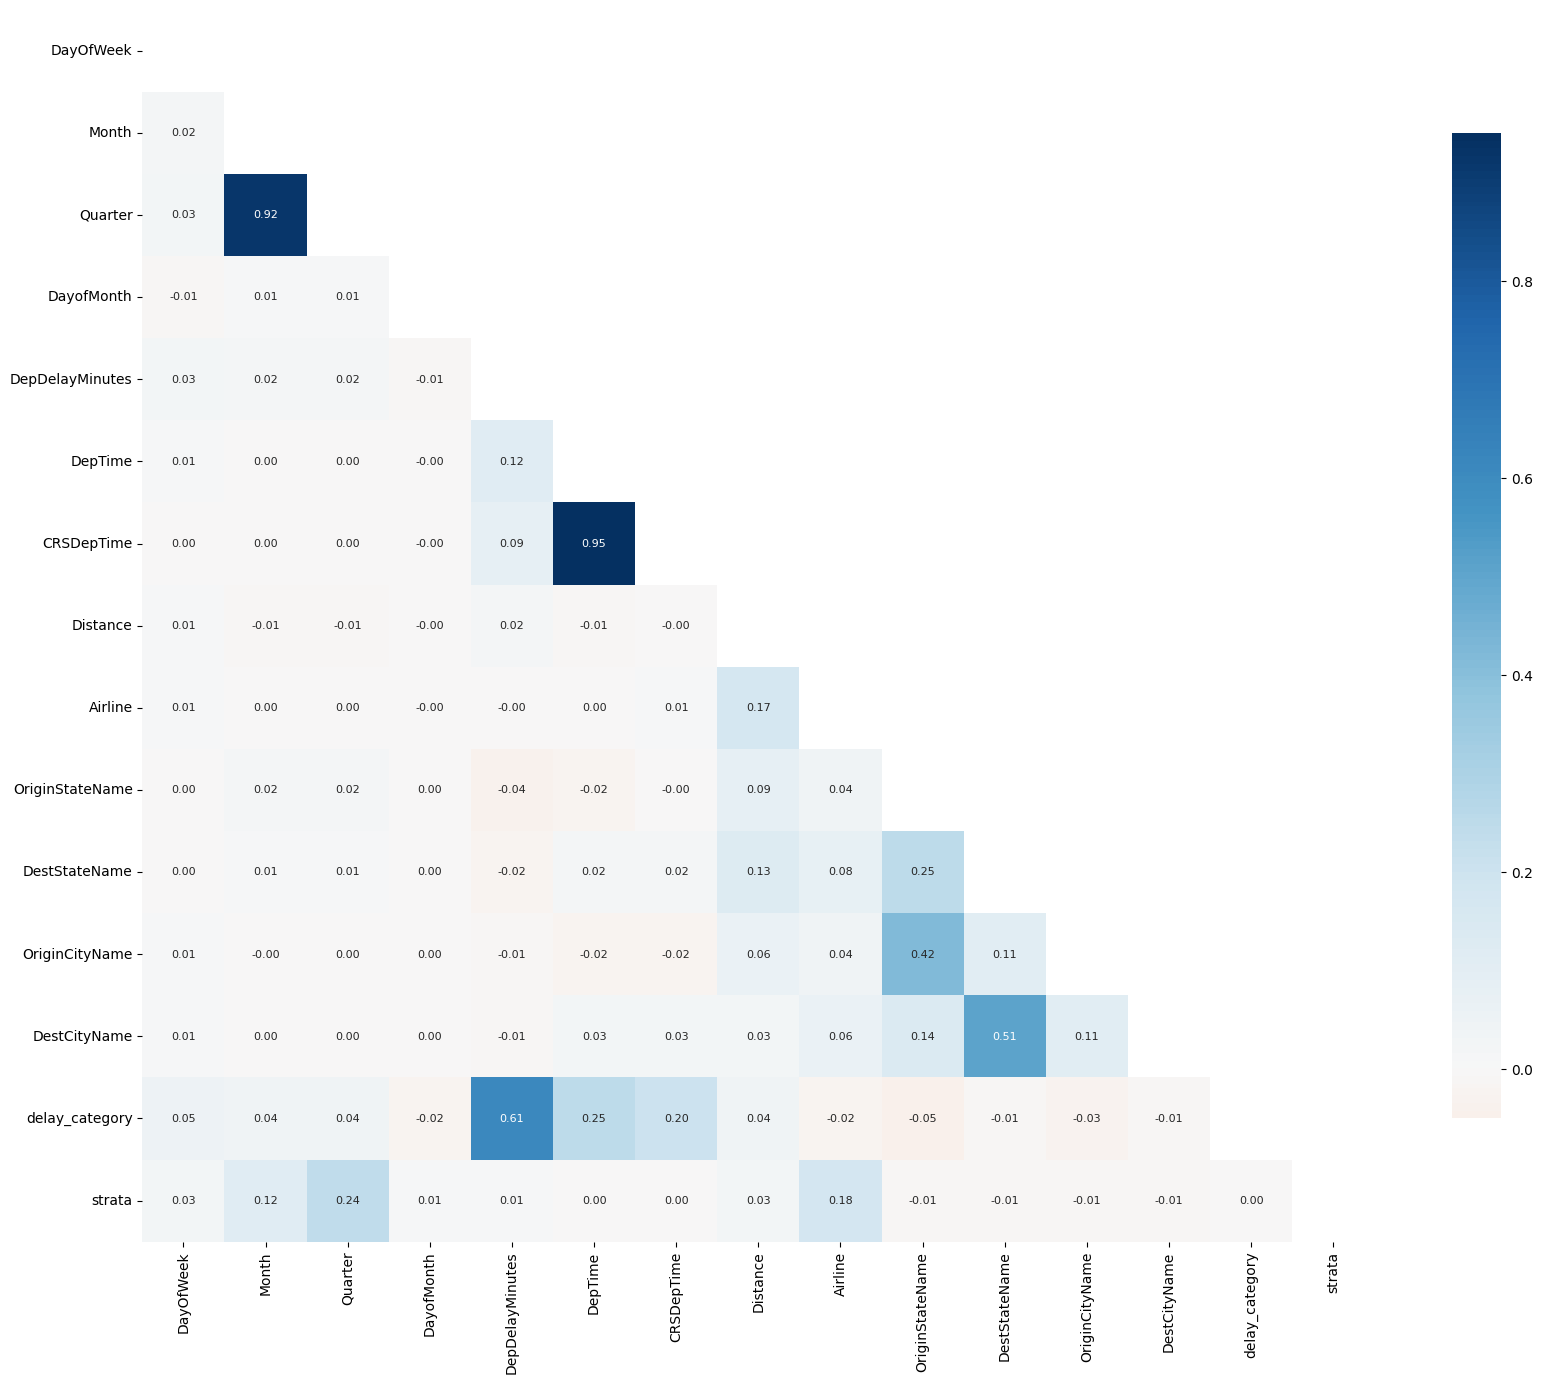

In [40]:
plt.figure(figsize=(20,16))
sns.heatmap(df_enc.corr().round(2), 
            annot=True,
            mask=np.triu(df_enc.corr()),
            cmap='RdBu',
            center=0,
            square=True,
            fmt='.2f',
            annot_kws={'size': 8},  
            cbar_kws={'shrink': .8}
            )
plt.show()

---

# 6. Feature Engineering

## 6.1 Creating new features 

### - Variable de franja horaria
Esto lo hacemos debido a que usualmente los vuelos son retrasados por franjas horarias. Y si se percatan no agregaremos los minutos exactos porque esto puede hacer que los datos esten muy granulados y podria generar un Overfitting del modelo

In [41]:
def convert_military_to_quarter_hour(time):
    if pd.isna(time):
        return np.nan
    
    time_str = str(int(time)).zfill(4)
    hour = int(time_str[:2])
    minutes = int(time_str[2:])
    
    # Convertir minutos a cuartos de hora
    quarter = (minutes // 15) * 0.25
    
    # Combinar hora con cuarto de hora
    return hour + quarter
    # Ejemplos:
    # 14:00 -> 14.0
    # 14:15 -> 14.25
    # 14:30 -> 14.5
    # 14:45 -> 14.75

# Aplicar la función
df_enc['HourBlock'] = df_enc['DepTime'].apply(convert_military_to_quarter_hour)

In [42]:
df_enc["HourBlock"].dtype

dtype('float64')

In [43]:
df_enc.head()

,DayOfWeek,Month,Quarter,DayofMonth,DepDelayMinutes,DepTime,CRSDepTime,Distance,Airline,OriginStateName,DestStateName,OriginCityName,DestCityName,delay_category,strata,HourBlock
0,1,4,2,4,0.0,1123.0,1133,212.0,0,0,0,0,0,0.0,0,11.25
1,1,4,2,4,0.0,728.0,732,295.0,0,1,1,1,1,0.0,0,7.25
2,1,4,2,4,0.0,1514.0,1529,251.0,0,0,0,2,0,0.0,0,15.00
3,1,4,2,4,0.0,1430.0,1435,376.0,0,1,2,3,2,0.0,0,14.50
4,1,4,2,4,0.0,1135.0,1135,251.0,0,0,0,2,0,0.0,0,11.50


### Convertir mis float64 y int64 a float32 e int32

## 6.2 Outlier Analysis

In [44]:
continuos_f = list(df_enc.select_dtypes('float64'))

In [39]:
'''continuos_f = list(df_enc.select_dtypes('float64'))

fig, ax = plt.subplots(5,3, figsize=(10, 20))

row, col = 0, 0
for each in df_enc.columns:
    sns.boxplot(ax = ax[row,col], data = df_enc, x=each).tick_params(labelsize=2)
    col += 1
    if col == 3: 
        row += 1 
        col = 0

plt.tight_layout()
plt.show()'''

"continuos_f = list(df_enc.select_dtypes('float64'))\n\nfig, ax = plt.subplots(5,3, figsize=(10, 20))\n\nrow, col = 0, 0\nfor each in df_enc.columns:\n    sns.boxplot(ax = ax[row,col], data = df_enc, x=each).tick_params(labelsize=2)\n    col += 1\n    if col == 3: \n        row += 1 \n        col = 0\n\nplt.tight_layout()\nplt.show()"

In [45]:
def remove_datetime_columns(df):
    return df.select_dtypes(exclude=['datetime64[ns]'])

In [46]:
df_enc_no = df_enc.copy()

In [47]:
def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*1.5)
    lower_lim = q1 - (iqr*1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))

    filename = f'../data/interim/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x

In [48]:
f_outliers_with_neg = []
f_outliers_no_neg = []

for each in continuos_f:
    if df_enc[each].min() < 0:
        f_outliers_with_neg.append(each)
    f_outliers_no_neg.append(each)

for feature in f_outliers_with_neg:
    df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature)

for feature in f_outliers_no_neg:
    try:
        df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature, allow_neg=False)
    except:
        continue

In [49]:
df_enc.isna().sum()[df_enc.isna().sum()>0]

Series([], dtype: int64)

In [50]:
remove_datetime_columns(df_enc)
remove_datetime_columns(df_enc_no)

,DayOfWeek,Month,Quarter,DayofMonth,DepDelayMinutes,DepTime,CRSDepTime,Distance,Airline,OriginStateName,DestStateName,OriginCityName,DestCityName,delay_category,strata,HourBlock
0,1,4,2,4,0.0,1123.0,1133,212.0,0,0,0,0,0,0.0,0,11.25
1,1,4,2,4,0.0,728.0,732,295.0,0,1,1,1,1,0.0,0,7.25
2,1,4,2,4,0.0,1514.0,1529,251.0,0,0,0,2,0,0.0,0,15.00
3,1,4,2,4,0.0,1430.0,1435,376.0,0,1,2,3,2,0.0,0,14.50
4,1,4,2,4,0.0,1135.0,1135,251.0,0,0,0,2,0,0.0,0,11.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590537,4,3,1,31,25.0,2014.0,1949,1167.0,5,7,17,133,28,2.0,146,20.00
590538,4,3,1,17,27.5,1817.0,1733,529.0,5,16,17,26,28,2.0,146,18.25
590539,2,3,1,8,27.5,2318.0,1700,723.0,5,9,19,16,36,2.5,108,23.25
590540,5,3,1,25,27.5,2322.0,2129,319.0,5,12,18,21,75,2.5,108,23.25


In [51]:
def split(target, df, test_size=0.2, random_state=42):
    X = df.drop(columns=target)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [52]:
# Split original dataframe 
X_train_with_outliers, X_test_with_outliers, y_train, y_test = split('DepDelayMinutes', df_enc)
X_train_without_outliers, X_test_without_outliers, _, _ = split('DepDelayMinutes', df_enc_no)

X_train_with_outliers.to_csv('../data/processed/X_train_with_outliers.csv', index=False)
X_test_with_outliers.to_csv('../data/processed/X_test_with_outliers.csv', index=False)
X_train_without_outliers.to_csv('../data/processed/X_train_without_outliers.csv', index=False)
X_test_without_outliers.to_csv('../data/processed/X_test_without_outliers.csv', index=False)

y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

In [53]:
X_test_with_outliers.head()

,DayOfWeek,Month,Quarter,DayofMonth,DepTime,CRSDepTime,Distance,Airline,OriginStateName,DestStateName,OriginCityName,DestCityName,delay_category,strata,HourBlock
344051,5,7,3,29,844.0,843,192.0,7,6,31,131,109,0.0,225,8.50
551009,5,7,3,29,1152.0,1155,436.0,4,7,1,133,103,0.0,244,11.75
559756,4,5,2,26,1904.0,1750,452.0,4,20,37,37,108,3.0,16,19.00
444821,6,7,3,16,1415.0,1300,2496.0,11,36,39,147,130,3.0,239,14.25
344409,3,3,1,30,728.0,730,862.0,9,0,35,4,105,0.0,84,7.25


In [54]:
def kselection(X_train, X_test, y_train, k, reference: str):
    selection_model = SelectKBest(f_classif, k=k)
    selection_model.fit(X_train, y_train)
    cols = selection_model.get_support()

    X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns.values[cols]) 
    X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=X_test.columns.values[cols])

    dump(selection_model, open(f'../data/processed/selection_model_{reference}.sav', 'wb'))

    return X_train_sel, X_test_sel

In [55]:
X_train_with_outliers_sel, X_test_with_outliers_sel = kselection(X_train_with_outliers, X_test_with_outliers, y_train, 'all', 'with_outliers')
X_train_without_outliers_sel, X_test_without_outliers_sel = kselection(X_train_without_outliers, X_test_without_outliers, y_train, 'all', 'without_outliers')

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [56]:
dfs_train = {
    'X_train_with_outliers_sel': X_train_with_outliers_sel,
    'X_train_without_outliers_sel': X_train_without_outliers_sel
}

dfs_test = {
    'X_test_with_outliers_sel': X_test_with_outliers_sel,
    'X_test_without_outliers_sel': X_test_without_outliers_sel   
}

for name, df in dfs_train.items():
    df.to_csv(f"../data/processed/{name}.csv", index=False)

for name, df in dfs_test.items(): 
    df.to_csv(f'../data/processed/{name}.csv', index=False)

In [57]:
train, test = [], []

for name, df in dfs_train.items():
    train.append(df)
for name, df in dfs_test.items():
    test.append(df)

In [58]:
X_train_with_outliers.columns

Index(['DayOfWeek', 'Month', 'Quarter', 'DayofMonth', 'DepTime', 'CRSDepTime',
       'Distance', 'Airline', 'OriginStateName', 'DestStateName',
       'OriginCityName', 'DestCityName', 'delay_category', 'strata',
       'HourBlock'],
      dtype='object')

In [59]:
X_train_with_outliers_sel.head()

,DayOfWeek,Month,Quarter,DayofMonth,DepTime,CRSDepTime,Distance,Airline,OriginStateName,DestStateName,OriginCityName,DestCityName,delay_category,strata,HourBlock
0,3.0,3.0,1.0,9.0,2038.0,2049.0,2173.0,11.0,6.0,36.0,116.0,104.0,0.0,113.0,20.50
1,4.0,4.0,2.0,7.0,2108.0,2112.0,102.0,16.0,1.0,1.0,158.0,262.0,0.0,61.0,21.00
2,1.0,4.0,2.0,18.0,730.0,730.0,2565.0,11.0,12.0,35.0,21.0,135.0,0.0,43.0,7.50
3,6.0,4.0,2.0,23.0,1829.0,1840.0,477.0,18.0,17.0,23.0,87.0,41.0,0.0,70.0,18.25
4,5.0,5.0,2.0,20.0,1006.0,1013.0,493.0,7.0,32.0,35.0,140.0,142.0,0.0,29.0,10.00


In [60]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def format_delay_time(minutes):
    """
    Convierte minutos en un formato legible de horas y minutos
    """
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    if hours > 0:
        return f"{hours}h {mins}min"
    return f"{mins}min"

results = []

# Parámetros base para XGBoost
xgb_params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 100,
    'objective': 'reg:squarederror',
    'random_state': 42
}

for index in range(len(train)):
    # Crear y entrenar el modelo XGBoost
    model = XGBRegressor(**xgb_params)
    train_df = train[index]
    model.fit(
        train_df, 
        y_train,
        eval_set=[(train_df, y_train)],
        verbose=False
    )
    
    # Realizar predicciones
    y_test_pred = model.predict(test[index])
    
    # Calcular predicciones medias y máximas
    mean_delay = np.mean(y_test_pred)
    max_delay = np.max(y_test_pred)
    
    # Obtener importancia de características
    feature_importance = model.feature_importances_
    
    results.append({
        'index': index,
        'df_train': list(dfs_train.keys())[index],
        'Feature_importance': feature_importance,
        'MAE': round(mean_absolute_error(y_test, y_test_pred), 2),
        'RMSE': round(root_mean_squared_error(y_test, y_test_pred), 2),
        'R2_score': round(r2_score(y_test, y_test_pred), 5),
        'Predicted_Mean_Delay': format_delay_time(mean_delay),
        'Predicted_Max_Delay': format_delay_time(max_delay),
        'model': model
    })

# Ordenar resultados por RMSE
results = sorted(results, key=lambda x: x['RMSE'])
best_ind = results[0]['index']
best_df_train = results[0]['df_train']
best_model = results[0]['model']

# Mostrar resultados sin el modelo
results_display = [{k: v for k, v in r.items() if k != 'model'} for r in results]

# Mostrar estadísticas de retraso para el mejor modelo
print("\nEstadísticas de retraso del mejor modelo:")
best_predictions = best_model.predict(test[best_ind])
print(f"Retraso promedio esperado: {format_delay_time(np.mean(best_predictions))}")
print(f"Retraso máximo esperado: {format_delay_time(np.max(best_predictions))}")
print(f"Retraso mínimo esperado: {format_delay_time(np.min(best_predictions))}")

# Para hacer una predicción específica con el mejor modelo:
def predict_delay(model, new_data):
    prediction = model.predict([new_data])[0]
    return format_delay_time(prediction)

# Ejemplo de uso:
# delay = predict_delay(best_model, test[best_ind].iloc[0])
# print(f"Retraso predicho para este vuelo: {delay}")

results_display


Estadísticas de retraso del mejor modelo:
Retraso promedio esperado: 16min
Retraso máximo esperado: 22h 16min
Retraso mínimo esperado: 40min


[{'index': 0,
  'df_train': 'X_train_with_outliers_sel',
  'Feature_importance': array([3.9262203e-03, 2.3917428e-03, 0.0000000e+00, 1.1860292e-03,
         1.3351460e-01, 7.0520043e-02, 1.5024889e-03, 1.0072899e-02,
         2.5250772e-03, 2.4646477e-04, 1.9338526e-04, 1.7404160e-03,
         6.9654405e-01, 6.4931344e-04, 7.4987248e-02], dtype=float32),
  'MAE': 2.82,
  'RMSE': np.float64(12.86),
  'R2_score': 0.93856,
  'Predicted_Mean_Delay': '16min',
  'Predicted_Max_Delay': '22h 16min'},
 {'index': 1,
  'df_train': 'X_train_without_outliers_sel',
  'Feature_importance': array([7.26996281e-04, 1.84995495e-03, 0.00000000e+00, 2.32616439e-03,
         1.34542093e-01, 7.19065815e-02, 1.31244014e-03, 1.02954665e-02,
         1.99434790e-03, 1.28459465e-03, 9.78228054e-05, 9.90306027e-04,
         6.98747337e-01, 6.81504840e-04, 7.32444823e-02], dtype=float32),
  'MAE': 2.84,
  'RMSE': np.float64(12.96),
  'R2_score': 0.93762,
  'Predicted_Mean_Delay': '16min',
  'Predicted_Max_Delay': 

In [61]:
results[results[0].get("index")].get('MAE')

2.82

In [62]:
print(f'Our best dataframe for our model is {best_df_train}, with a MAE of {results[results[0].get("index")].get("MAE")}, \
a RMSE of {results[results[0].get("index")].get("RMSE")} and a R2_score of {results[results[0].get("index")].get("R2_score")}')

Our best dataframe for our model is X_train_with_outliers_sel, with a MAE of 2.82, a RMSE of 12.86 and a R2_score of 0.93856


In [63]:
# Verificar que el modelo está prediciendo valores diferentes en el conjunto de prueba original
y_test_pred = best_model.predict(test[best_ind])
print("Muestra de predicciones en el conjunto de prueba:")
print(y_test_pred[:10])  # Primeras 10 predicciones
print(f"\nRango de predicciones:")
print(f"Mínimo: {min(y_test_pred)}")
print(f"Máximo: {max(y_test_pred)}")
print(f"Media: {np.mean(y_test_pred)}")

Muestra de predicciones en el conjunto de prueba:
[ 0.21902032  0.563536   69.391106   80.79426     0.38642684  0.4010397
  0.15909696  0.36228892  0.3708206  11.415043  ]

Rango de predicciones:
Mínimo: -19.77821922302246
Máximo: 1336.4515380859375
Media: 16.00269317626953


In [64]:
# Crear casos con valores extremos
casos_extremos = pd.DataFrame({
    'DayOfWeek':       [1.0, 7.0],    
    'Month':           [1.0, 12.0],    
    'Quarter':         [1.0, 4.0],    
    'DayofMonth':      [1.0, 31.0],    
    'DepTime':         [0.0, 2359.0], 
    'CRSDepTime':      [0.0, 2359.0],
    'Distance':        [100.0, 3000.0],
    'Airline':         [min(X_train_with_outliers_sel['Airline']), max(X_train_with_outliers_sel['Airline'])],
    'OriginStateName': [min(X_train_with_outliers_sel['OriginStateName']), max(X_train_with_outliers_sel['OriginStateName'])],
    'DestStateName':   [min(X_train_with_outliers_sel['DestStateName']), max(X_train_with_outliers_sel['DestStateName'])],
    'OriginCityName':  [min(X_train_with_outliers_sel['OriginCityName']), max(X_train_with_outliers_sel['OriginCityName'])],
    'DestCityName':    [min(X_train_with_outliers_sel['DestCityName']), max(X_train_with_outliers_sel['DestCityName'])],
    'delay_category':  [0.0, 1.0],
    'strata':          [min(X_train_with_outliers_sel['strata']), max(X_train_with_outliers_sel['strata'])],
    'HourBlock':       [0.0, 23.0]
})

predicciones_extremas = best_model.predict(casos_extremos)
print("\nPredicciones con valores extremos:")
for i, pred in enumerate(predicciones_extremas):
    print(f"Caso extremo {i+1}: {format_delay_time(pred)}")


Predicciones con valores extremos:
Caso extremo 1: 34min
Caso extremo 2: 11min


In [65]:
casos_prueba = pd.DataFrame({
    # 1: Peor escenario - Vuelo en temporada alta, viernes por la tarde
    # 2: Mejor escenario - Vuelo temprano, día entre semana
    # 3: Caso típico - Vuelo de media distancia en horario normal
    # 4: Caso de alto riesgo - Último vuelo del día
    'DayOfWeek':       [5.0,   2.0,    3.0,    7.0],    
    'Month':           [12.0,  4.0,    7.0,    7.0],    
    'Quarter':         [4.0,   2.0,    3.0,    3.0],    
    'DayofMonth':      [23.0,  12.0,   15.0,   20.0],    
    'DepTime':         [1700.0, 600.0, 1400.0, 2300.0],
    'CRSDepTime':      [1700.0, 600.0, 1400.0, 2300.0],
    'Distance':        [2500.0, 500.0, 1000.0, 800.0],
    'Airline':         [11.0,  16.0,   7.0,    20.0],    
    'OriginStateName': [6.0,   12.0,   32.0,   17.0],   
    'DestStateName':   [36.0,  35.0,   23.0,   23.0],
    'OriginCityName':  [116.0, 21.0,   140.0,  87.0],
    'DestCityName':    [104.0, 135.0,  41.0,   44.0],
    'delay_category':  [1.0,   0.0,    0.0,    1.0],
    'strata':          [113.0, 43.0,   70.0,   80.0],
    'HourBlock':       [17.0,  6.0,    14.0,   23.0]    
})

predicciones = best_model.predict(casos_prueba)

print("Análisis detallado de predicciones:")

print("\nCaso 1 - Peor escenario (Viernes, temporada alta):")
print(f"Fecha: Viernes 23 de Diciembre")
print(f"Hora: 17:00 (Rush hour)")
print(f"Distancia: 2500 millas (Vuelo largo)")
print(f"Retraso predicho: {format_delay_time(predicciones[0])}")

print("\nCaso 2 - Mejor escenario (Martes temprano):")
print(f"Fecha: Martes 12 de Abril")
print(f"Hora: 06:00")
print(f"Distancia: 500 millas (Vuelo corto)")
print(f"Retraso predicho: {format_delay_time(predicciones[1])}")

print("\nCaso 3 - Caso típico (Mitad de semana):")
print(f"Fecha: Miércoles 15 de Julio")
print(f"Hora: 14:00")
print(f"Distancia: 1000 millas")
print(f"Retraso predicho: {format_delay_time(predicciones[2])}")

print("\nCaso 4 - Último vuelo del día:")
print(f"Fecha: Domingo 20 de Julio")
print(f"Hora: 23:00")
print(f"Distancia: 800 millas")
print(f"Retraso predicho: {format_delay_time(predicciones[3])}")

Análisis detallado de predicciones:

Caso 1 - Peor escenario (Viernes, temporada alta):
Fecha: Viernes 23 de Diciembre
Hora: 17:00 (Rush hour)
Distancia: 2500 millas (Vuelo largo)
Retraso predicho: 11min

Caso 2 - Mejor escenario (Martes temprano):
Fecha: Martes 12 de Abril
Hora: 06:00
Distancia: 500 millas (Vuelo corto)
Retraso predicho: 0min

Caso 3 - Caso típico (Mitad de semana):
Fecha: Miércoles 15 de Julio
Hora: 14:00
Distancia: 1000 millas
Retraso predicho: 0min

Caso 4 - Último vuelo del día:
Fecha: Domingo 20 de Julio
Hora: 23:00
Distancia: 800 millas
Retraso predicho: 11min


## Guardar el modelo

In [66]:
#Ruta
model_filename = "../models/flight_delay_model.pkl"

#Guardar el modelo usando pickle
with open(model_filename, "wb") as file:
    pickle.dump(best_model, file)

print(f"✅ Modelo guardado en {model_filename}")

✅ Modelo guardado en ../models/flight_delay_model.pkl


In [72]:
X_test_with_outliers.head()

,DayOfWeek,Month,Quarter,DayofMonth,DepTime,CRSDepTime,Distance,Airline,OriginStateName,DestStateName,OriginCityName,DestCityName,delay_category,strata,HourBlock
344051,5,7,3,29,844.0,843,192.0,7,6,31,131,109,0.0,225,8.50
551009,5,7,3,29,1152.0,1155,436.0,4,7,1,133,103,0.0,244,11.75
559756,4,5,2,26,1904.0,1750,452.0,4,20,37,37,108,3.0,16,19.00
444821,6,7,3,16,1415.0,1300,2496.0,11,36,39,147,130,3.0,239,14.25
344409,3,3,1,30,728.0,730,862.0,9,0,35,4,105,0.0,84,7.25


In [69]:
y_test.head()

344051     1.0
551009     0.0
559756    74.0
444821    75.0
344409     0.0
Name: DepDelayMinutes, dtype: float64